# Import Data and Libraries

In [8]:
!pip list

Package                       Version
----------------------------- ------------
absl-py                       2.0.0
affine                        2.4.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.4
aioitertools                  0.11.0
aiosignal                     1.3.1
aiosqlite                     0.19.0
altair                        5.1.0
anyio                         4.0.0
appdirs                       1.4.4
arcgis2geojson                2.0.1
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
asciitree                     0.3.3
asttokens                     2.4.0
astunparse                    1.6.3
async-timeout                 4.0.2
attrs                         23.1.0
awscli                        1.27.163
Babel                         2.12.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.5
beautifulsoup4                4.12.2
black   

In [14]:
!pip install sklearn_pandas

In [15]:
import datetime
from jdcal import jd2gcal
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import xarray as xr
import geopandas as gpd
from matplotlib import pyplot as plt

import cdsapi
import sklearn_pandas as skp

custom_colors = ['68A33E', '#A10702', '#FB9E60', '#FFFF82', '#0F0326']

# Load in Raw Data

In [16]:
##################################################
##### 1. Loading raw data #####
input_filename = './Data/FPA_FOD_20170508.sqlite'
conn = sqlite3.connect(input_filename)
query = '''
    SELECT
        NWCG_REPORTING_AGENCY, NWCG_REPORTING_UNIT_ID,
        NWCG_REPORTING_UNIT_NAME,
        FIRE_NAME,
        COMPLEX_NAME,
        FIRE_YEAR,
        DISCOVERY_DATE,
        DISCOVERY_DOY,
        DISCOVERY_TIME,
        CONT_DATE,
        CONT_DOY,
        CONT_TIME,
        FIRE_SIZE,
        FIRE_SIZE_CLASS,
        OWNER_CODE,
        OWNER_DESCR,
        LATITUDE,
        LONGITUDE,
        STATE,
        COUNTY
    FROM
        Fires;
'''
df_raw = pd.read_sql_query(query, conn)
df_raw.info()



OperationalError: unable to open database file

In [17]:
input_filename = './Data/FPA_FOD_20170508.sqlite'
conn = sqlite3.connect(input_filename)
query = '''
    SELECT
       *
    FROM
        Fires;
'''
df_raw = pd.read_sql_query(query, conn)
df_raw.info()

OperationalError: unable to open database file

# Clean Data and Extract Oregon Boundaries

In [ ]:
##################################################
##### 2. Cleaning data and extracting Oregon #####
drop_columns = ['NWCG_REPORTING_AGENCY',
                'NWCG_REPORTING_UNIT_ID',
                'NWCG_REPORTING_UNIT_NAME',
                'FIRE_NAME',
                'COMPLEX_NAME', 
                'OWNER_DESCR',
                'FIRE_SIZE_CLASS',
                'OWNER_CODE']
#df_CA = df_raw[df_raw.STATE == 'CA'].drop(columns=drop_columns)
df_OR = df_raw[df_raw.STATE == 'OR'].drop(columns=drop_columns)
#Extracting onset month and day
df_OR['MONTH'] = df_OR['DISCOVERY_DATE'].apply(lambda x: jd2gcal(x, 0)[1])
df_OR['DAY'] = df_OR['DISCOVERY_DATE'].apply(lambda x: jd2gcal(x, 0)[2])
df_OR.head(2)

us_states = gpd.read_file("./Data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp")
oregon = us_states[us_states['NAME'] == 'Oregon']
oregon.plot(ax=plt.gca(), color='white', edgecolor='red')
plt.title("Oregon Boundary")
plt.axis('off')
plt.show()

# Monthly/Seasonaly fire frequency

In [ ]:

custom_colors = ['#68A33E','#FFFF82','#FB9E60','#A10702', '#0F0326']  # Add your desired hex colors

#custom_cmap = ListedColormap(custom_colors)

##################################################
##### 3. Monthly/seasonal fire frequency #####
df_freq_mon = df_OR.groupby(['MONTH', 'FIRE_YEAR']).size().unstack()
# plot monthly frequency of fire events
counter_fig = 1
mon_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=[11,5])
sns.heatmap(df_freq_mon, cmap=custom_colors, linewidth=.2, linecolor=[.9,.9,.9])
plt.yticks(np.arange(0.5,12.5), labels=mon_ticks, rotation=0, fontsize=12)
plt.xticks(fontsize=12);
plt.xlabel('')
plt.ylabel('Month', fontsize=13)
plt.title(f'Fig {counter_fig}. Number of fire events in Oregon', fontsize=13)
plt.tight_layout()
#plt.savefig(f'../Figures/Fig{counter_fig}.png', format='png', dpi=200)

# plot fire frequency by cause and day of year
cause_by_doy = df_OR.groupby(['STAT_CAUSE_DESCR','DISCOVERY_DOY']).size().unstack()
counter_fig +=1
plt.figure(figsize=[10,5])
ax = sns.heatmap(cause_by_doy,cmap=custom_colors,vmin=0,vmax=500) #'CMRmap_r' <- old color scheme
plt.xticks(np.arange(0.5,366.5,20), labels=range(1,366,20), rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Fire Cause', fontsize=12)
plt.xlabel('Day of year', fontsize=12)
for borders in ["top","right","left","bottom"]:
    ax.spines[borders].set_visible(True)
plt.title(f'Fig {counter_fig}. Distribution of OR fires by cause & day of year')
plt.tight_layout()
#plt.savefig(f'../Figures/Fig{counter_fig}.png', format='png', dpi=200)



# Download and Extract Climate Data (ERAS)

In [26]:
import os

# Get the user directory within the current environment
env_name = 'musa-550-fall-2023'
env_user_dir = os.path.join(os.environ['CONDA_PREFIX'], 'envs', env_name)

print(f"User directory in {env_name} environment: {env_user_dir}")

User directory in musa-550-fall-2023 environment: C:\Users\shrey\mambaforge\envs\musa-550-fall-2023\envs\musa-550-fall-2023


In [27]:
ds_era5 = xr.open_dataset('ERA5_monthly.nc')

In [28]:
##################################################
##### 4. Download and extract climate data (ERA5) #####

import cdsapi

def _download_era5(variables: list, filename: str):
    c = cdsapi.Client()
    c.retrieve(
        'reanalysis-era5-single-levels-monthly-means',
        {
            'format': 'netcdf',
            'product_type': 'monthly_averaged_reanalysis',
            'variable': variables,
            'year': [f'{yr}' for yr in range(2002,2004)],  # Adjust the range of years as needed
            'month': [f'{x:02.0f}' for x in range(1,13)],  # Include all months
            'time': '00:00',
            'area': [46.3, -124.6, 42.4, -122.9],  # Oregon coordinates
        },
        f'{filename}.nc'
    )

vars_all = ['total_precipitation', '2m_temperature', '2m_dewpoint_temperature',
            '10m_wind_speed', 'volumetric_soil_water_layer_1', 'potential_evaporation']

_download_era5(vars_all, 'ERA5_monthly')

#ds_era5 = xr.open_dataset('ERA5_monthly.nc')
# load Oregon mask file
#OR_mask = oregon

2023-12-23 07:41:43,226 INFO Welcome to the CDS
2023-12-23 07:41:43,227 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-12-23 07:41:43,541 INFO Request is queued
2023-12-23 07:41:44,813 INFO Request is running
2023-12-23 07:42:05,966 INFO Request is completed
2023-12-23 07:42:05,967 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data0/adaptor.mars.internal-1703335320.0684383-21234-18-093948c7-4e32-4fd7-af86-1a7a12574f99.nc to ERA5_monthly.nc (33.9K)
2023-12-23 07:42:09,960 INFO Download rate 8.5K/s                                                                      


# Assessing climate trends

NameError: name 'OR_mask' is not defined

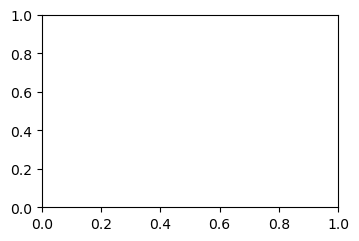

In [29]:
##################################################
##### 5. Assessing climate trends #####
# plot climate trends
#ds_era5 = "./'ERA5_monthly.nc'"



import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load data from the NetCDF file into ds_era5
ds_era5 = xr.open_dataset('ERA5_monthly.nc')  # Replace 'ERA5_monthly.nc' with your actual file path

counter_fig = 0
counter_fig += 1
var = list(ds_era5.data_vars)
# Rest of the code remains the same...


import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Assuming ds_era5 is an xarray dataset loaded from the NetCDF file
counter_fig = 0
counter_fig +=1
var = list(ds_era5.data_vars)
titles = {"tp":"Precipitation (mm)",
         "t2m":"Air temperature at 2m (°C)",
         "d2m":"Dew point temperature (°C)",
         "si10":"Wind speed at 10m",
         "swvl1":"Near surface soil moisture",
         "pev":"Potential evapotranspiration (mm)"}
unit_conversion = {"tp": [1000*365,0], #convert default units to mm and °C -->[*multiply, *add]
                   "t2m": [1,-273.15], 
                   "d2m": [1,-273.15],
                   "si10": [1,0],
                   "swvl1": [1,0],
                   "pev": [-1000*365,0]}
fig = plt.figure(figsize=(13, 5.5))
gs = gridspec.GridSpec(2, 3) 
for i in range(len(var)):
    plt.subplot(gs[i])
    (ds_era5[var[i]].where(OR_mask).mean(['latitude','longitude']).groupby(
        ds_era5.time.dt.year).mean()*unit_conversion[var[i]][0] + \
        unit_conversion[var[i]][1]).plot(color='g')
    plt.xlabel('')
    plt.grid(axis='y')
    plt.title(titles[var[i]], fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../Figures/Fig{counter_fig}.png', format='png', dpi=200)


# Assessing the climate factors affecting fires

In [ ]:
##################################################
##### 6. Assessing the climate factors affecting fires #####
df_freq = pd.DataFrame(df_OR.groupby(['FIRE_YEAR','MONTH']).size(), columns=['Frequency'])
df_freq = df_freq.reset_index().rename(columns={'FIRE_YEAR':'Year', 'MONTH':'Month'})
# extract monthly ERA5 data
def extract_era5_yr_mon(yr, mon, var):
    unit_conversion = {"tp": [1000*30,0], #convert default units to mm and °C -->[*multiply, +add]
                       "t2m": [1,-273.15], 
                       "d2m": [1,-273.15],
                       "si10": [1,0],
                       "swvl1": [1,0],
                       "pev": [-1000*30,0]}
    ds_yr_mon = ds_era5.sel(time = ds_era5.time.dt.month.isin(mon) & ds_era5.time.dt.year.isin(yr))
    output = float(ds_yr_mon[var].where(OR_mask).mean(['latitude','longitude']).values) * \
    unit_conversion[var][0] + unit_conversion[var][1]
    return output

# adding climate data to the dataframe
for i in range(len(var)):
    df_freq[var[i]] = df_freq.apply(lambda x: extract_era5_yr_mon(x.Year, x.Month, var[i]), axis=1)

# plotting scatter matrix for summer (MJJAS)
plt.style.use('seaborn')
counter_fig +=1
df_freq_summer = df_freq[df_freq.Month.isin([5,6,7,8,9])]
pd.plotting.scatter_matrix(df_freq_summer.drop(
    columns=['Year','Month']), alpha=0.5, color='g', figsize=(11, 11), diagonal='kde',);
plt.tight_layout()
plt.savefig(f'Fig{counter_fig}.png', format='png', dpi=200)

# calculate correlation between fire frequency and climate variables
def calculate_R2(array1, array2):
    return np.corrcoef(array1,array2)[0,1]

df_corr=np.zeros(len(var))
for i in range(len(var)):
    df_corr[i] = calculate_R2(df_freq_summer['Frequency'], df_freq_summer[var[i]])
    
# plot correlation results
counter_fig +=1
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=var, y=df_corr, palette='Spectral')
plt.plot([-1,6],[0,0],':k',linewidth=1.3)
plt.xticks(ticks=range(6), labels=['Precipitation', 'Air temperature', 'Dew point temperature',
                                  'Wind speed', 'Soil moisture', 'Potential Evapotranspiration'],
          fontsize=11, rotation=-90)
plt.xlim([-.5,5.5])
plt.yticks(fontsize=11)
plt.ylabel('Correlation Coefficient', fontsize=11.5)
plt.tight_layout()
plt.savefig(f'Fig{counter_fig}.png', format='png', dpi=200)



# Setup the ANN model

In [ ]:
##################################################
##### 7. Setup the ANN model #####
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

def ANN_fit(X,y):
    # temporal split into train and test
    ind_split = int(len(y)*.7)
    X_train = X[:ind_split];    X_test = X[ind_split:]
    y_train = y[:ind_split];    y_test = y[ind_split:]
    
    # scaling data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # setting up and fitting the model
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    model = Sequential()
    model.add(Dense(16,activation='relu'))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(8,activation='relu'))
    #model.add(Dense(4,activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=3500, validation_data=(X_test, y_test), 
                        verbose=0, shuffle=False, callbacks=[early_stop])
    
    # plotting the loss function
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
    # predicting the test period 
    test_predictions = model.predict(X_test)
    test_predictions = pd.Series(test_predictions.reshape(test_predictions.shape[0], )) 
    pred_df = pd.DataFrame(y_test, columns=['Test True Y']) 
    pred_df = pd.concat([pred_df, test_predictions], axis=1)
    pred_df.columns = ['Test True Y', 'Model Prediction']
    pred_df['Year'] = df_freq[ind_split:].Year.values
    pred_df['Month'] = df_freq[ind_split:].Month.values

    return pred_df

# Fitting the ANN Model

In [ ]:
##################################################
##### 8. Fitting the ANN model #####
plt.style.use('ggplot')
y = df_freq['Frequency'].values
X = df_freq.drop(columns=['Frequency']).values
pred_df = ANN_fit(X, y)

# plotting the prediction vs. observation
counter_fig +=1
plt.figure(figsize=[11,5])
plt.plot(pred_df['Test True Y'], color='g', linewidth=2, label='Truth')
plt.plot(pred_df['Model Prediction'], color='r', linewidth=2, label='Prediction')
plt.xticks(ticks=range(0,len(pred_df),12), labels=pred_df.Year[::12])
plt.ylim(bottom=0)
plt.ylabel('Number of fire events', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(f'Fig{counter_fig+1}.png', format='png', dpi=200)